<a href="https://colab.research.google.com/github/mersalas/ecosa/blob/main/ecoli_uhl_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install packages
!pip install pyforest
!pip install deepchem
!pip install shap

  Preparing metadata (setup.py) ... done
  Created wheel for pyforest: filename=pyforest-1.1.0-py2.py3-none-any.whl size=14605 sha256=0f233d777a274de57571a7e0c3f86f51916d443159f11a8c10fa95601b6ff356
  Stored in directory: /root/.cache/pip/wheels/9e/7d/2c/5d2f5e62de376c386fd3bf5a8e5bd119ace6a9f48f49df6017
Successfully built pyforest
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 34.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.3
    Uninstalling scipy-1.11.3:
      Successfully uninstalled scipy-1.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is no

In [2]:
# Import necessary libraries
from pyforest import*
lazy_imports() # load most libraries
import deepchem as dc
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, StackingClassifier
import joblib
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, matthews_corrcoef, cohen_kappa_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import shap
from shap import Explanation
from shap.plots import waterfall
shap.initjs()

In [3]:
# Featurize smiles
dataset_file = 'https://raw.githubusercontent.com/mersalas/ecosa/main/dataset/Ecoli_uhl.csv'
tasks = ['Ecoli']

featurizer = dc.feat.CircularFingerprint(radius=6, size=2048, chiral = True, bonds = True)
loader = dc.data.CSVLoader(tasks=tasks, feature_field='smiles', featurizer=featurizer)
dataset = loader.create_dataset(dataset_file)

In [4]:
# Split dataset into train & test sets
X_train, X_test, y_train, y_test = train_test_split(dataset.X, dataset.y, test_size=0.20, random_state=42, stratify=dataset.y)

print("Size of training set: {}   size of test set:"
      " {}\n".format(X_train.shape[0], X_test.shape[0]))

<IPython.core.display.Javascript object>

Size of training set: 1768   size of test set: 442



In [5]:
# Train SVC
svc = SVC(C=5.2956, kernel='rbf', gamma=6.9212e-3, class_weight='balanced', probability=True,
          random_state=42)
svc.fit(X_train, np.ravel(y_train))

<IPython.core.display.Javascript object>

SVC(C=5.2956, class_weight='balanced', gamma=0.0069212, probability=True,
    random_state=42)

In [6]:
# Train XGB
xgb = XGBClassifier(tree_method='hist', device='cuda', objective='binary:logistic', scale_pos_weight=1,
                    learning_rate=0.091724, n_estimators=624, gamma=1.0573e-5, max_depth=19, subsample=0.73961,
                    colsample_bytree=0.75069, alpha=0.057571, random_state=42)
xgb.fit(X_train, np.ravel(y_train))

<IPython.core.display.Javascript object>

XGBClassifier(alpha=0.057571, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.75069, device='cuda',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.0573e-05,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.091724,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=19, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=624, n_jobs=None,
              num_parallel_tree=None, ...)

In [7]:
# Train LGBM
lgbm = LGBMClassifier(device='cpu', objective='binary', is_unbalance=True, n_estimators=965, learning_rate=0.19893,
                      num_leaves=195, max_depth=10, min_data_in_leaf=99, bagging_fraction=0.8, bagging_freq=1,
                      feature_fraction=0.5, verbose=-1, random_state=42)
lgbm.fit(X_train, np.ravel(y_train))

<IPython.core.display.Javascript object>

LGBMClassifier(bagging_fraction=0.8, bagging_freq=1, device='cpu',
               feature_fraction=0.5, is_unbalance=True, learning_rate=0.19893,
               max_depth=10, min_data_in_leaf=99, n_estimators=965,
               num_leaves=195, objective='binary', random_state=42, verbose=-1)

In [8]:
# Train voting model
vote = VotingClassifier(estimators=[('svc', svc), ('xgb', xgb), ('lgbm', lgbm)], voting='soft')

vote.fit(X_train, np.ravel(y_train))

<IPython.core.display.Javascript object>

VotingClassifier(estimators=[('svc',
                              SVC(C=5.2956, class_weight='balanced',
                                  gamma=0.0069212, probability=True,
                                  random_state=42)),
                             ('xgb',
                              XGBClassifier(alpha=0.057571, base_score=None,
                                            booster=None, callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.75069,
                                            device='cuda',
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metri...
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=624, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('lgbm',
                              LGBMClassifier(bagging_fraction=0.8,
                                             bagging_freq=1, device='cpu',
                                             feature_fraction=0.5,
                                             is_unbalance=True,
                                             learning_rate=0.19893,
                                             max_depth=10, min_data_in_leaf=99,
                                             n_estimators=965, num_leaves=195,
                                             objective='binary',
                                             random_state=42, verbose=-1))],
                 voting='soft')

In [9]:
# Evaluate the voting model on training set
print("Performance of evaluation metrics on training set")
y_train_pred = cross_val_predict(vote, X_train, np.ravel(y_train), cv=10)
print("accuracy score: {:.2f}".format(accuracy_score(y_train, y_train_pred)))
print("kappa score: {:.2f}".format(cohen_kappa_score(y_train, y_train_pred)))
print("precision score: {:.2f}".format(precision_score(y_train, y_train_pred)))
print("sensitivity score: {:.2f}".format(recall_score(y_train, y_train_pred)))
print("ROC-AUC: {:.2f}".format(roc_auc_score(y_train, y_train_pred)))
print("f1 score: {:.2f}".format(f1_score(y_train, y_train_pred)))
print("MCC score: {:.2f}".format(matthews_corrcoef(y_train, y_train_pred)))

Performance of evaluation metrics on training set


<IPython.core.display.Javascript object>

[20:40:19] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



accuracy score: 0.82
kappa score: 0.62
precision score: 0.83
sensitivity score: 0.87
ROC-AUC: 0.81
f1 score: 0.85
MCC score: 0.62


In [10]:
# Save the model
joblib.dump(vote, "ecoli_uhl.pkl")

['ecoli_uhl.pkl']

In [11]:
# Load the model
ecoli = joblib.load('ecoli_uhl.pkl')

In [12]:
# Evaluate the voting model on test set
y_pred = ecoli.predict(X_test)
y_proba = ecoli.predict_proba(X_test)[:, 1]
print("Performance of evaluation metrics on test set")
print("accuracy score: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("kappa score: {:.2f}".format(cohen_kappa_score(y_test, y_pred)))
print("precision score: {:.2f}".format(precision_score(y_test, y_pred)))
print("sensitivity score: {:.2f}".format(recall_score(y_test, y_pred)))
print("ROC-AUC: {:.2f}".format(roc_auc_score(y_test, y_proba)))
print("f1 score: {:.2f}".format(f1_score(y_test, y_pred)))
print("MCC score: {:.2f}".format(matthews_corrcoef(y_test, y_pred)))

Performance of evaluation metrics on test set
accuracy score: 0.83
kappa score: 0.64
precision score: 0.84
sensitivity score: 0.86
ROC-AUC: 0.88
f1 score: 0.85
MCC score: 0.64


In [13]:
# Featurize own peptides
dataset_file = 'https://raw.githubusercontent.com/mersalas/ecosa/main/dataset/Ecoli_uhl_test.csv'
tasks = ['Ecoli']

featurizer = dc.feat.CircularFingerprint(radius=6, size=2048, chiral = True, bonds = True)
loader = dc.data.CSVLoader(tasks=tasks, feature_field='smiles', featurizer=featurizer)
dataset = loader.create_dataset(dataset_file)

In [14]:
# Convert dataset.X to dataframe
X = pd.DataFrame(dataset.X)
col = ['ECFP' + str(x) for x in range(0,2048)]
X.columns = col
X.head()

<IPython.core.display.Javascript object>

,ECFP0,ECFP1,ECFP2,ECFP3,ECFP4,ECFP5,ECFP6,ECFP7,ECFP8,ECFP9,...,ECFP2038,ECFP2039,ECFP2040,ECFP2041,ECFP2042,ECFP2043,ECFP2044,ECFP2045,ECFP2046,ECFP2047
0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Predict activity of own peptides
pred = ecoli.predict(X)
pred

X has feature names, but SVC was fitted without feature names


array([1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.])

**Feature importance**

In [16]:
# SHAP values
explainer = shap.KernelExplainer(ecoli.predict, X)
shap_values = explainer.shap_values(X)

  0%|          | 0/11 [00:00<?, ?it/s]

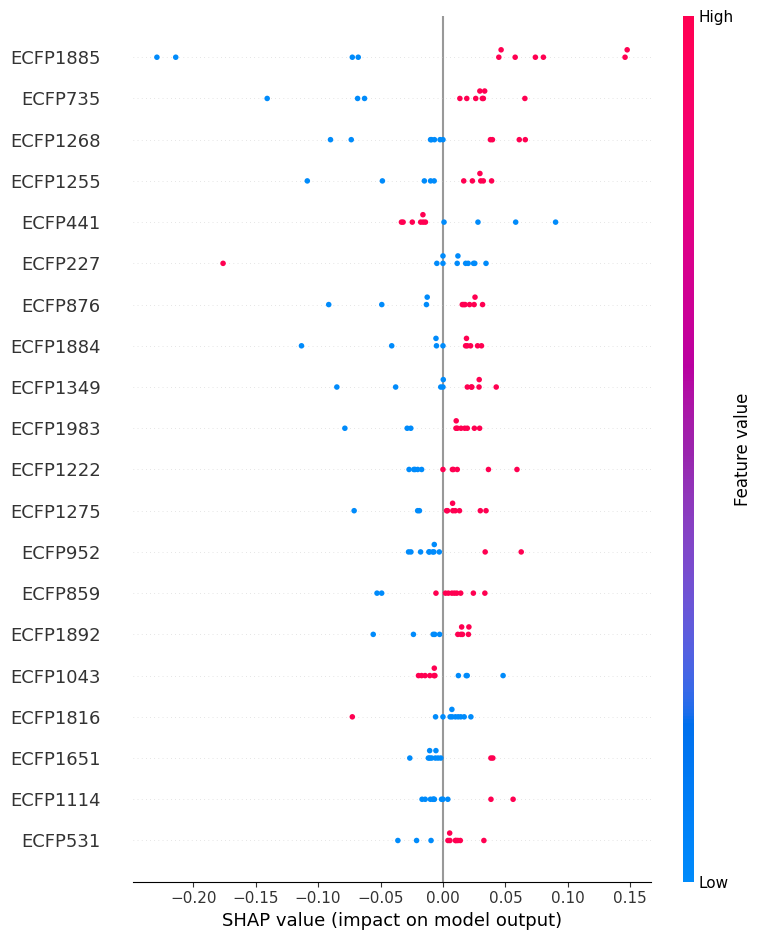

In [17]:
shap.summary_plot(shap_values, X)

In [18]:
# Plot the SHAP values for the 1st observation as force plot
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

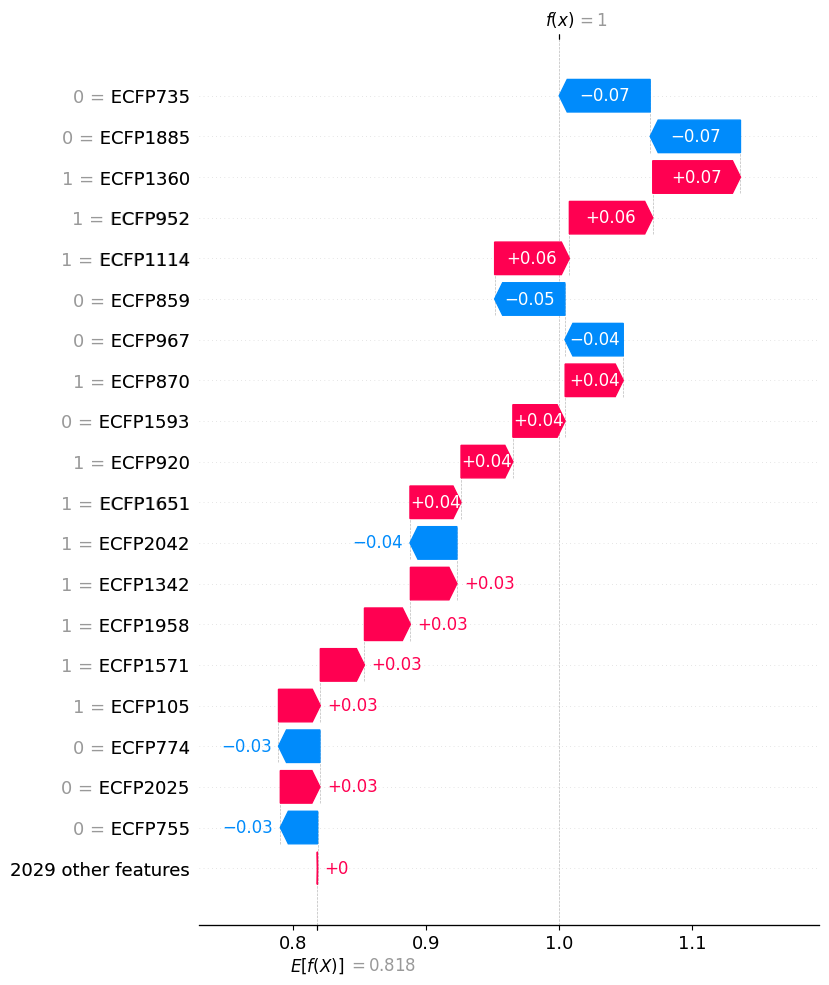

In [19]:
# Plot the SHAP values for the 1st observation as waterfall
exp = Explanation(shap_values, explainer.expected_value, data=X.loc[[0]].values, feature_names=X.columns)
waterfall(exp[0], max_display=20)

**C2K-OHR**

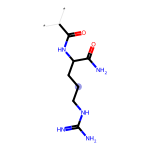

In [20]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
mol = Chem.MolFromSmiles('NC(=O)C(CCCNC(=N)N)NC(=O)C(NC(=O)C(CCCN)NC(=O)C(CCCCNC(=O)CCCC1CCCCC1)NC(=O)CCCC1CCCCC1)Cc1cnc[NH]1')
bi = {}
fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=6, bitInfo=bi, nBits=2048)
bi[1360]
mfp1 = Draw.DrawMorganBit(mol, 1360, bi, useSVG=True)
mfp1

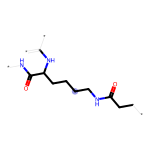

In [21]:
bi[952]
mfp2 = Draw.DrawMorganBit(mol, 952, bi, useSVG=True)
mfp2

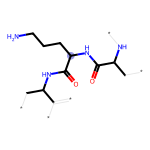

In [22]:
bi[870]
mfp3 = Draw.DrawMorganBit(mol, 870, bi, useSVG=True)
mfp3

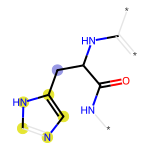

In [23]:
bi[1651]
mfp4 = Draw.DrawMorganBit(mol, 1651, bi, useSVG=True)
mfp4

**C2K-SHf-1**

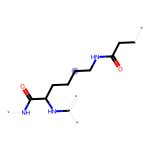

In [24]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
mol = Chem.MolFromSmiles('NC(=O)C(NC(=O)C(CCCN)NC(=O)C(CCCN)NC(=O)C(NC(=O)C(Cc1ccccc1)NC(=O)C(Cc1cnc[NH]1)NC(=O)C(NC(=O)C(CCCCNC(=O)CCCC1CCCCC1)NC(=O)CCCC1CCCCC1)Cc1cnc[NH]1)C(C)CC)C(C)CC')
bi = {}
fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=6, bitInfo=bi, nBits=2048)
bi[952]
mfp1 = Draw.DrawMorganBit(mol, 952, bi, useSVG=True)
mfp1

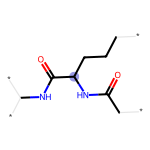

In [25]:
bi[1342]
mfp2 = Draw.DrawMorganBit(mol, 1342, bi, useSVG=True)
mfp2

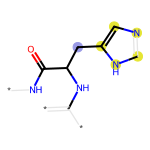

In [26]:
bi[1651]
mfp3 = Draw.DrawMorganBit(mol, 1651, bi, useSVG=True)
mfp3